In [1]:
!pip install -q segmentation-models-pytorch tqdm albumentations ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
folder_path = '/kaggle/input/cell-counting-roboflow-segmentation-masks/aug_inference_only/images' 
file_list = os.listdir(folder_path) # Bỏ comment dòng này nếu bạn đọc file từ thư mục

sorted_list = sorted(file_list, key=lambda x: int(x.split('_')[0]))

# In ra kết quả
print("Danh sách file gốc:")
print(file_list)
print("\nDanh sách file đã sắp xếp theo STT:")
print(sorted_list)

Danh sách file gốc:
['29_GT300_aug3.jpg', '8_GT44_aug3.jpg', '20_GT874_aug3.jpg', '35_GT300_aug3.jpg', '4_GT44_aug3.jpg', '21_GT913_aug3.jpg', '17_GT236_aug3.jpg', '9_GT52_aug2.jpg', '30_GT300_aug3.jpg', '33_GT43_aug3.jpg', '32_GT99_aug2.jpg', '28_GT261_aug2.jpg', '2_GT60_aug1.jpg', '13_GT36_aug1.jpg', '13_GT36_aug2.jpg', '16_GT60_aug2.jpg', '28_GT261_aug1.jpg', '13_GT36_aug3.jpg', '27_GT319_aug2.jpg', '26_GT386_aug1.jpg', '17_GT236_aug1.jpg', '21_GT913_aug2.jpg', '12_GT58_aug1.jpg', '10_GT46_aug2.jpg', '35_GT300_aug1.jpg', '24_GT422_aug1.jpg', '5_GT54_aug3.jpg', '3_GT60_aug1.jpg', '31_GT300_aug3.jpg', '23_GT838_aug2.jpg', '30_GT300_aug1.jpg', '29_GT300_aug1.jpg', '1_GT89_aug3.jpg', '34_GT298_aug2.jpg', '9_GT52_aug3.jpg', '16_GT60_aug3.jpg', '20_GT874_aug2.jpg', '3_GT60_aug2.jpg', '27_GT319_aug3.jpg', '12_GT58_aug3.jpg', '18_GT258_aug3.jpg', '25_GT401_aug1.jpg', '19_GT365_aug2.jpg', '6_GT68_aug1.jpg', '32_GT99_aug1.jpg', '21_GT913_aug1.jpg', '19_GT365_aug3.jpg', '15_GT46_aug3.jpg', '34

In [3]:
def estimate_average_cell_diameter(image_path):
    """
    Hàm này ước tính đường kính trung bình của các tế bào trong ảnh.
    Đây là một phương pháp phỏng đoán, hoạt động bằng cách tìm các vùng trắng trên nền đen.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Áp dụng ngưỡng Otsu để tự động tách nền và vật thể
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Tìm các thành phần liên thông (các tế bào)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    
    areas = []
    # Bỏ qua label 0 (là background)
    for i in range(1, num_labels):
        # Lọc bỏ các chấm nhiễu quá nhỏ hoặc các vật thể quá lớn
        if 10 < stats[i, cv2.CC_STAT_AREA] < 50000:
            areas.append(stats[i, cv2.CC_STAT_AREA])

    if not areas:
        return None # Không tìm thấy tế bào nào phù hợp

    # Tính đường kính từ diện tích trung bình (Area = pi * r^2)
    avg_area = np.mean(areas)
    avg_radius = np.sqrt(avg_area / np.pi)
    avg_diameter = avg_radius * 2
    
    return avg_diameter

In [ ]:
# ===================================================================
# IMPORTS VÀ ĐỊNH NGHĨA TẤT CẢ CÁC HÀM
# ===================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from ultralytics import YOLO
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# --- HÀM XỬ LÝ ẢNH ---
def preprocess_image(image, use_sobel_sharpening=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_contrast = clahe.apply(gray)
    if not use_sobel_sharpening:
        return cv2.cvtColor(enhanced_contrast, cv2.COLOR_GRAY2RGB)
    else:
        sobelx = cv2.Sobel(enhanced_contrast, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(enhanced_contrast, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = cv2.magnitude(sobelx, sobely)
        sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        combined_image = cv2.addWeighted(enhanced_contrast, 0.7, sobel_magnitude, 0.3, 0)
        return cv2.cvtColor(combined_image, cv2.COLOR_GRAY2RGB)

def post_process_mask(mask, min_area=25, open_kernel_size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_kernel_size, open_kernel_size))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(opened_mask, connectivity=8)
    cleaned_mask = np.zeros_like(opened_mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned_mask[labels == i] = 255
    return cleaned_mask

def count_objects(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

# --- HÀM TRỰC QUAN HÓA ---
def visualize_unet_prediction(original_bgr_image, cleaned_mask, num_objects, border_size=2, color=(0, 255, 0)):
    overlay = original_bgr_image.copy()
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, color, border_size)
    original_rgb = cv2.cvtColor(original_bgr_image, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1); plt.imshow(original_rgb); plt.title('Original Image'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(cleaned_mask, cmap='gray'); plt.title('Cleaned Mask'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(overlay_rgb); plt.title(f'U-Net Detected: {num_objects}'); plt.axis('off')
    plt.tight_layout(); plt.show()

def visualize_yolo_prediction(original_bgr_image, yolo_results, num_objects, color=(0, 255, 0), thickness=2):
    overlay = original_bgr_image.copy()
    for box in yolo_results[0].boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = box[:4]
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        radius = int(min(x2 - x1, y2 - y1) / 2)
        cv2.circle(overlay, (center_x, center_y), radius, color, thickness)
    original_rgb = cv2.cvtColor(original_bgr_image, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(original_rgb); plt.title('Original Image'); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(overlay_rgb); plt.title(f'YOLO Detections: {num_objects}'); plt.axis('off')
    plt.tight_layout(); plt.show()

# --- HÀM PIPELINE (QUY TRÌNH XỬ LÝ) ---
def predict_unet_mask(model, device, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        binary = probs[:, 1, :, :] > 0.5
        return binary.cpu().numpy().astype(np.uint8) * 255

def unet_counting_pipeline(model, device, image_path, transform, min_area=25):
    image = cv2.imread(image_path)
    if image is None: return 0, None, None
    TARGET_CELL_DIAMETER = 60.0 # Đặt đường kính mục tiêu
    
    current_diameter = estimate_average_cell_diameter(image_path)
    
    if current_diameter is not None and current_diameter > 0:
        resize_factor = TARGET_CELL_DIAMETER / current_diameter
        new_height = int(image.shape[0] * resize_factor)
        new_width = int(image.shape[1] * resize_factor)
        
        # Ghi đè biến 'image' bằng ảnh đã được resize
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    # -----------------------------------------------------------------
    
    orig_h, orig_w = image.shape[:2]
    preprocessed_rgb = preprocess_image(image)
    transformed = transform(image=preprocessed_rgb)
    input_tensor = transformed["image"].unsqueeze(0)
    
    pred_mask_batch = predict_unet_mask(model, device, input_tensor)
    pred_mask = pred_mask_batch[0]
    mask_resized = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    cleaned_mask = post_process_mask(mask_resized, min_area=min_area)
    num_objects = count_objects(cleaned_mask)
    
    return num_objects, cleaned_mask, image

def count_cells_yolo(model, image_path, conf_threshold=0.45):
    img = cv2.imread(image_path)
    if img is None: return 0, None, None
    results = model(img, verbose=False, conf=conf_threshold)
    num_objects = len(results[0].boxes)
    return num_objects, img, results

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# ===================================================================
# LOAD MODEL VÀ ĐỊNH NGHĨA TRANSFORM
# ===================================================================

# --- Transform ---
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

# --- Load U-Net Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_unet = smp.Unet(
    encoder_name="resnet152",
    encoder_weights="imagenet",
    classes=2,
    activation=None,
)
model_unet = nn.DataParallel(model_unet)
model_unet.load_state_dict(torch.load("/kaggle/input/cells-counting/pytorch/default/2/kaggle/working/cell_models/best_unet_model.pth", map_location=device))
model_unet.to(device)
model_unet.eval()
print(f"U-Net model loaded successfully on device: {device}")

# --- Load YOLO Model ---
model_path_yolo = '/kaggle/input/cells-counting/pytorch/default/2/kaggle/working/cell_models/best.pt'
model_yolo = YOLO(model_path_yolo)
print("YOLO model loaded successfully.")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

U-Net model loaded successfully on device: cpu
YOLO model loaded successfully.


Bắt đầu đánh giá trên 105 ảnh...
Tham số U-Net: min_area = 20
Tham số YOLO: conf_threshold = 0.5
Các ảnh sẽ được hiển thị kết quả: [7, 10, 12, 18, 25, 38, 43, 47, 93]
------------------------------------------------------------
Ảnh 1/105: GT=89, UNet=42, YOLO=85
Ảnh 2/105: GT=89, UNet=48, YOLO=83
Ảnh 3/105: GT=89, UNet=46, YOLO=80
Ảnh 4/105: GT=60, UNet=51, YOLO=55
Ảnh 5/105: GT=60, UNet=55, YOLO=44
Ảnh 6/105: GT=60, UNet=45, YOLO=46
Ảnh 7/105: GT=60, UNet=57, YOLO=63
Ảnh 8/105: GT=60, UNet=55, YOLO=55
   ---> Đang hiển thị kết quả trực quan cho ảnh 8...


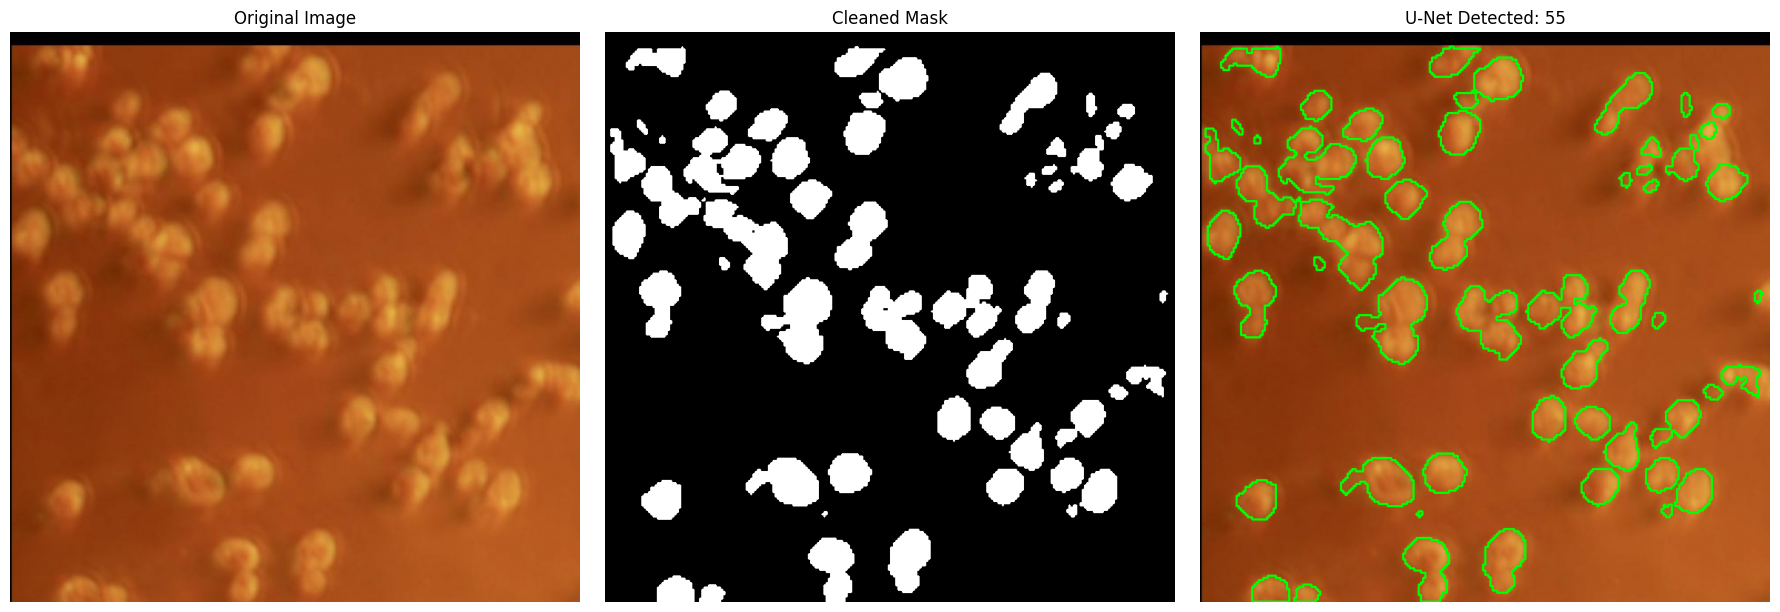

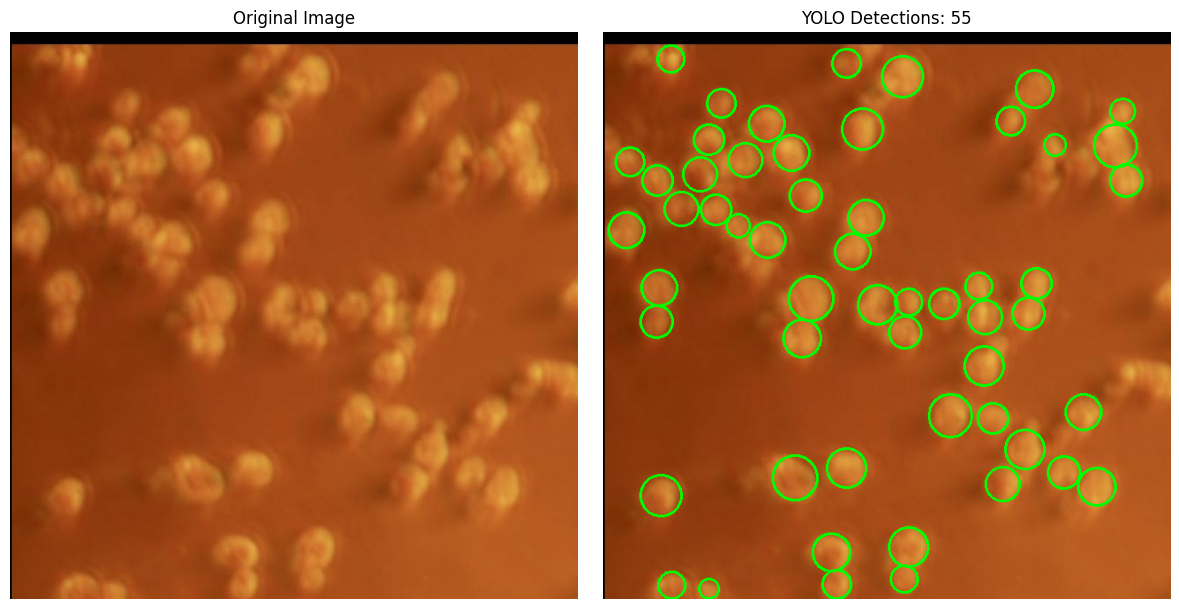

Ảnh 9/105: GT=60, UNet=51, YOLO=53
Ảnh 10/105: GT=44, UNet=42, YOLO=33
Ảnh 11/105: GT=44, UNet=36, YOLO=42
   ---> Đang hiển thị kết quả trực quan cho ảnh 11...


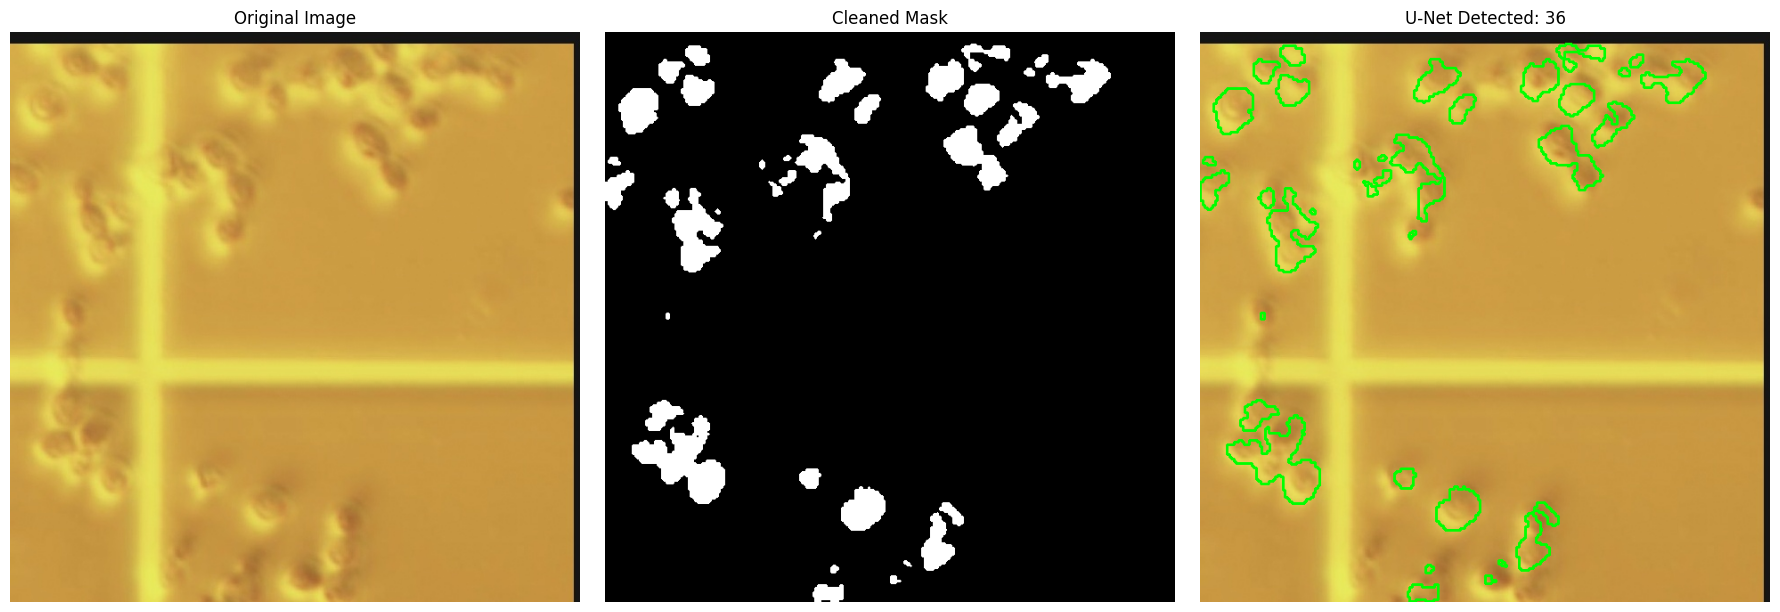

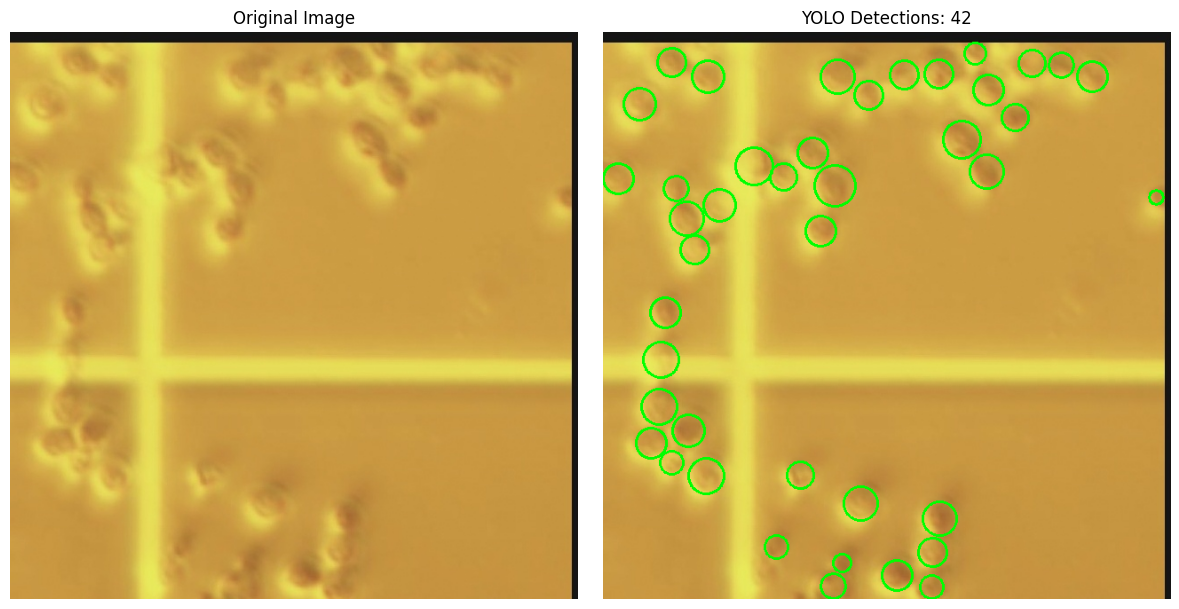

Ảnh 12/105: GT=44, UNet=37, YOLO=30
Ảnh 13/105: GT=54, UNet=50, YOLO=54
   ---> Đang hiển thị kết quả trực quan cho ảnh 13...


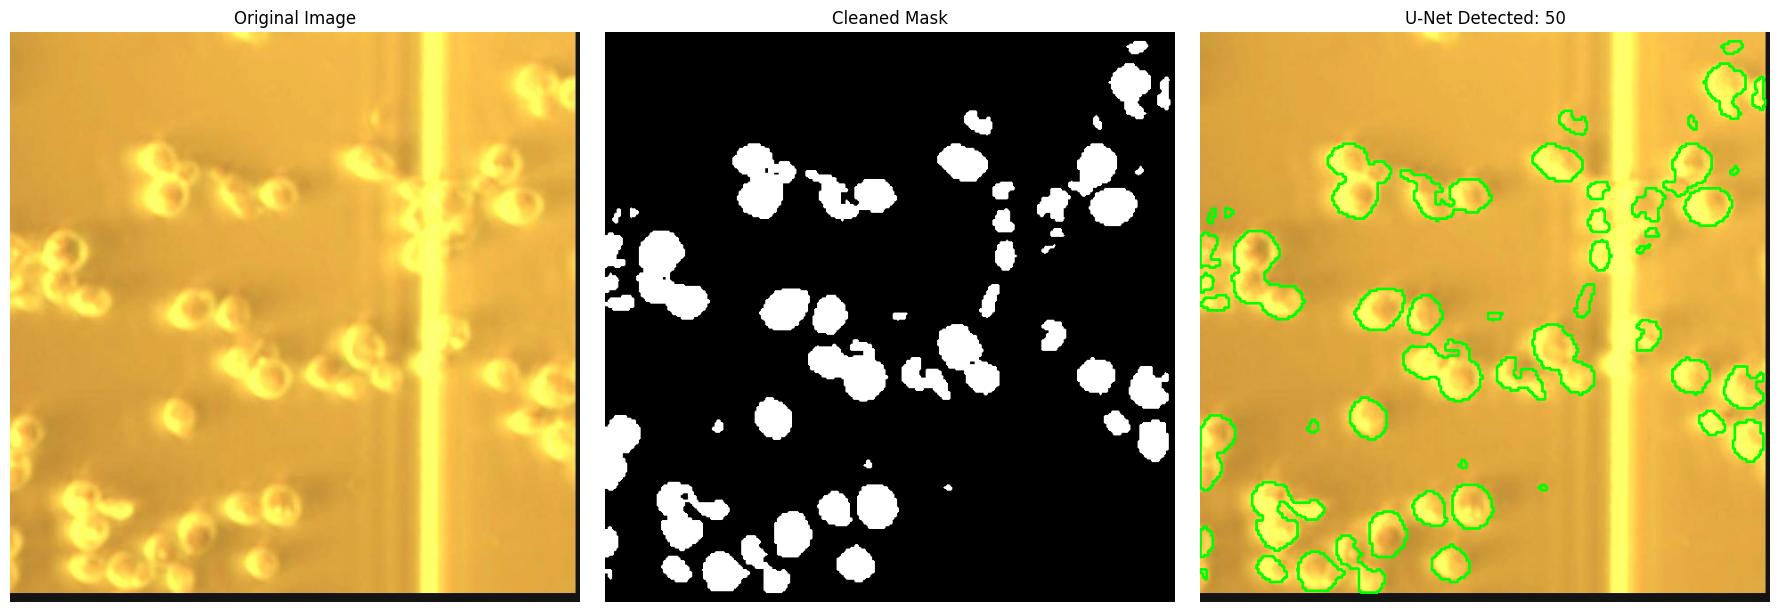

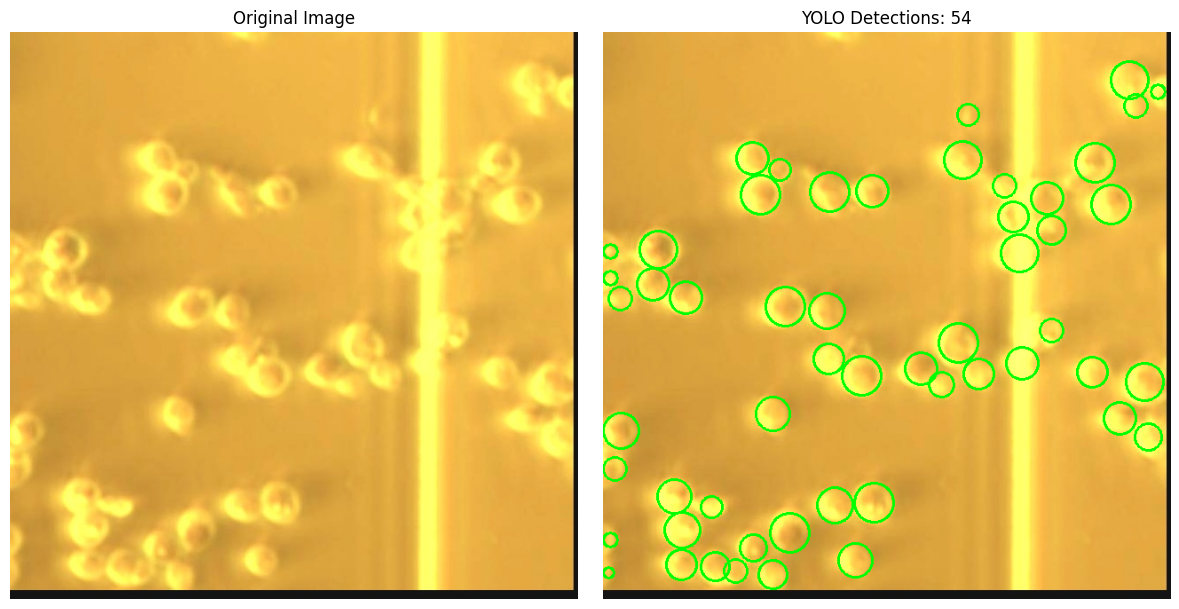

Ảnh 14/105: GT=54, UNet=43, YOLO=54
Ảnh 15/105: GT=54, UNet=43, YOLO=47
Ảnh 16/105: GT=68, UNet=45, YOLO=51
Ảnh 17/105: GT=68, UNet=46, YOLO=63
Ảnh 18/105: GT=68, UNet=52, YOLO=41
Ảnh 19/105: GT=48, UNet=44, YOLO=50
   ---> Đang hiển thị kết quả trực quan cho ảnh 19...


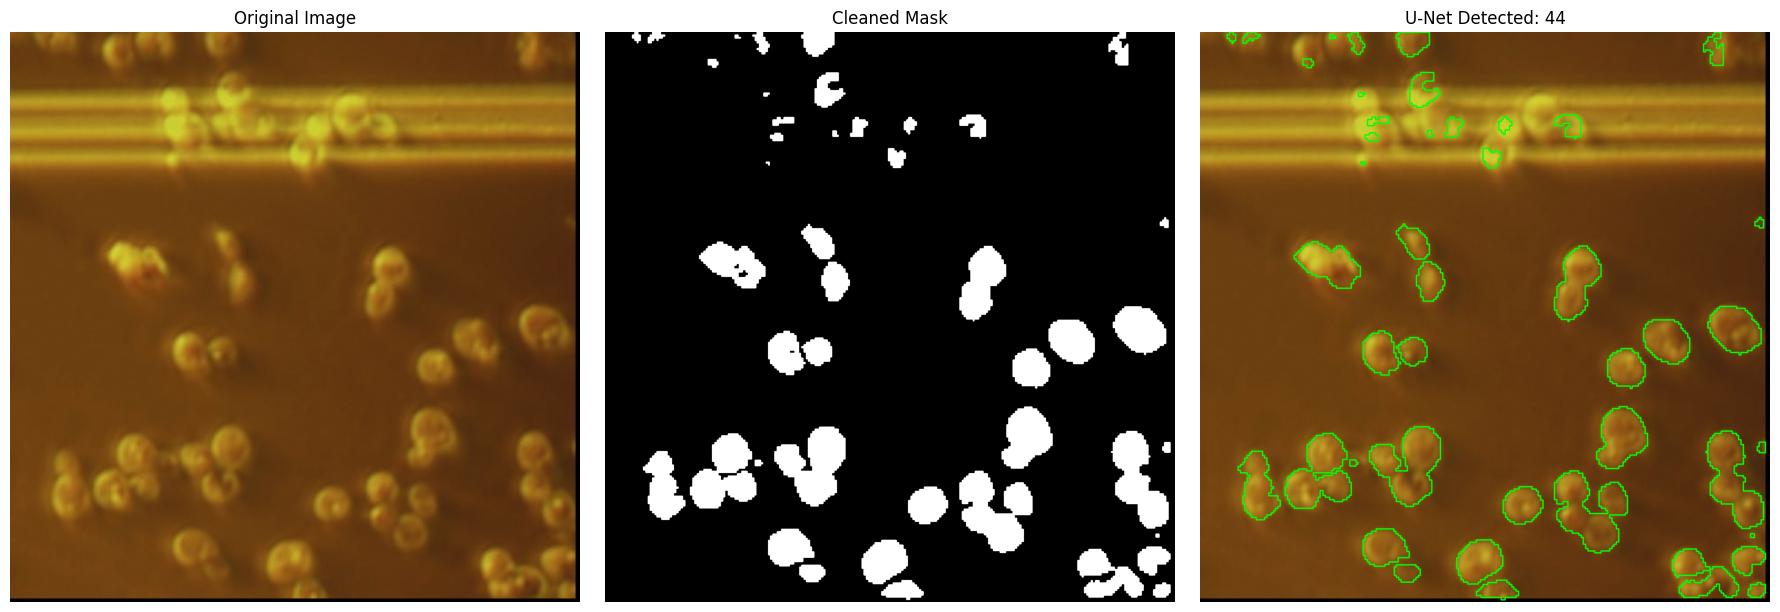

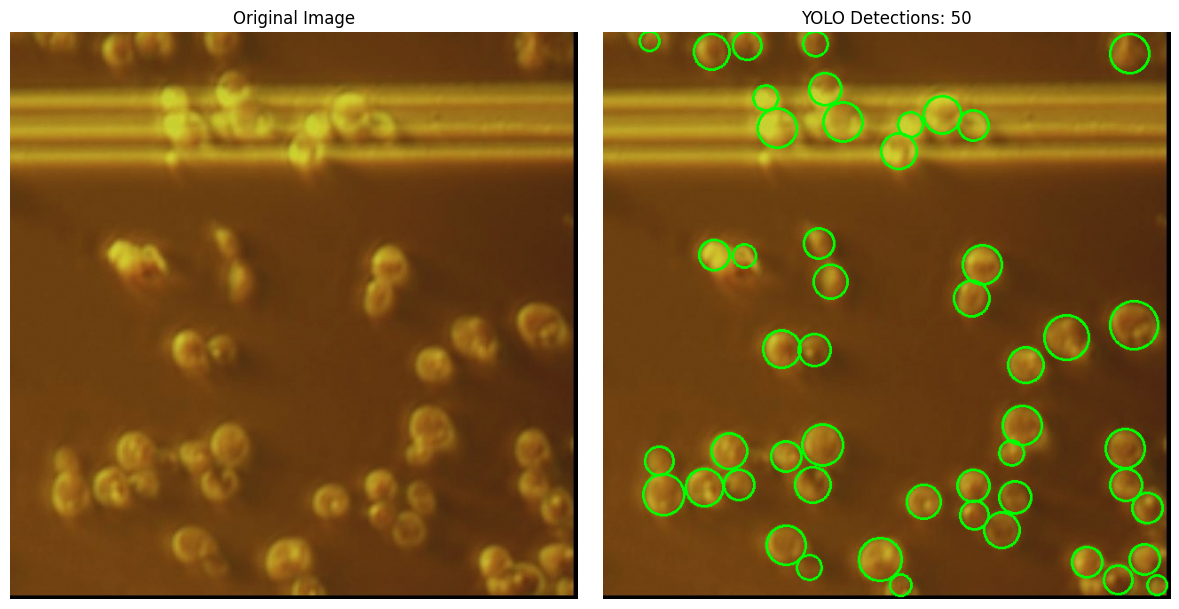

Ảnh 20/105: GT=48, UNet=44, YOLO=53
Ảnh 21/105: GT=48, UNet=46, YOLO=50
Ảnh 22/105: GT=44, UNet=61, YOLO=45
Ảnh 23/105: GT=44, UNet=53, YOLO=43
Ảnh 24/105: GT=44, UNet=63, YOLO=25
Ảnh 25/105: GT=52, UNet=45, YOLO=37
Ảnh 26/105: GT=52, UNet=49, YOLO=50
   ---> Đang hiển thị kết quả trực quan cho ảnh 26...


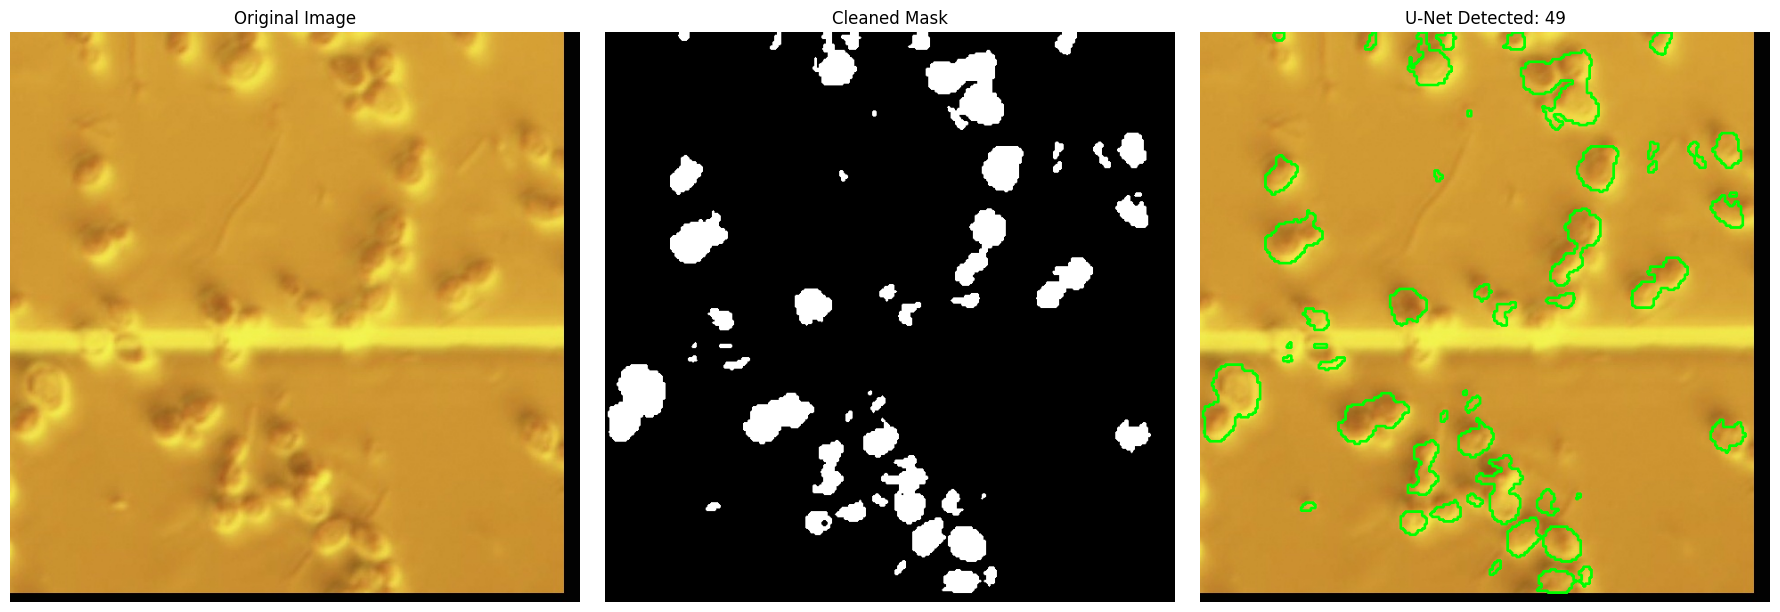

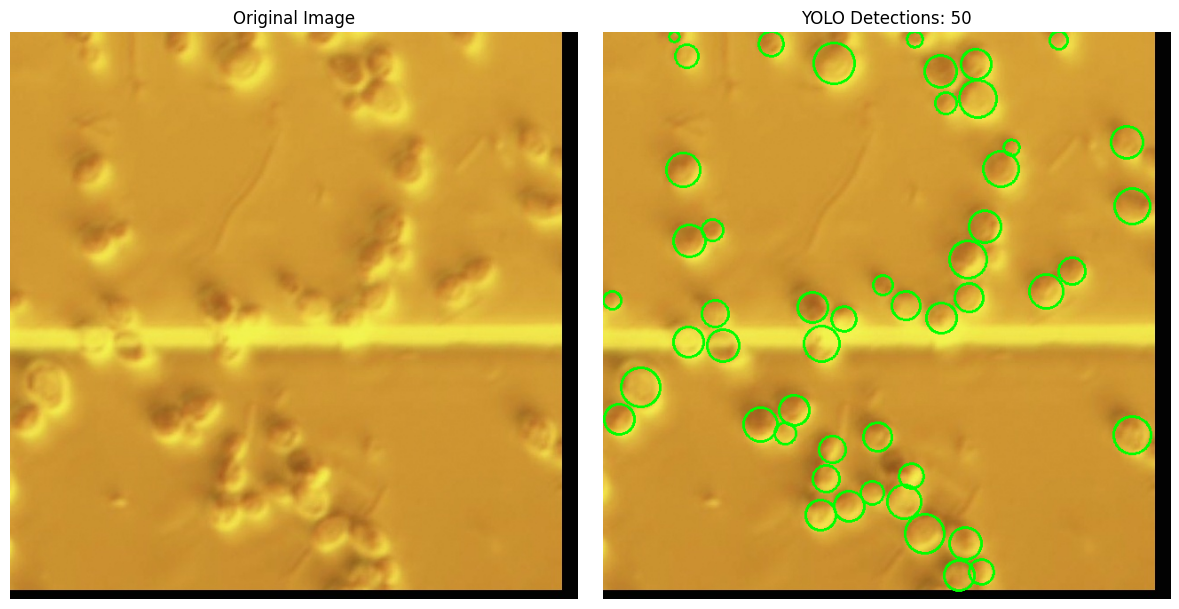

Ảnh 27/105: GT=52, UNet=54, YOLO=54
Ảnh 28/105: GT=46, UNet=55, YOLO=46
Ảnh 29/105: GT=46, UNet=64, YOLO=45
Ảnh 30/105: GT=46, UNet=49, YOLO=45
Ảnh 31/105: GT=41, UNet=29, YOLO=38
Ảnh 32/105: GT=41, UNet=38, YOLO=43
Ảnh 33/105: GT=41, UNet=44, YOLO=39
Ảnh 34/105: GT=58, UNet=65, YOLO=52
Ảnh 35/105: GT=58, UNet=65, YOLO=62
Ảnh 36/105: GT=58, UNet=66, YOLO=60
Ảnh 37/105: GT=36, UNet=44, YOLO=36
Ảnh 38/105: GT=36, UNet=35, YOLO=38
Ảnh 39/105: GT=36, UNet=33, YOLO=36
   ---> Đang hiển thị kết quả trực quan cho ảnh 39...


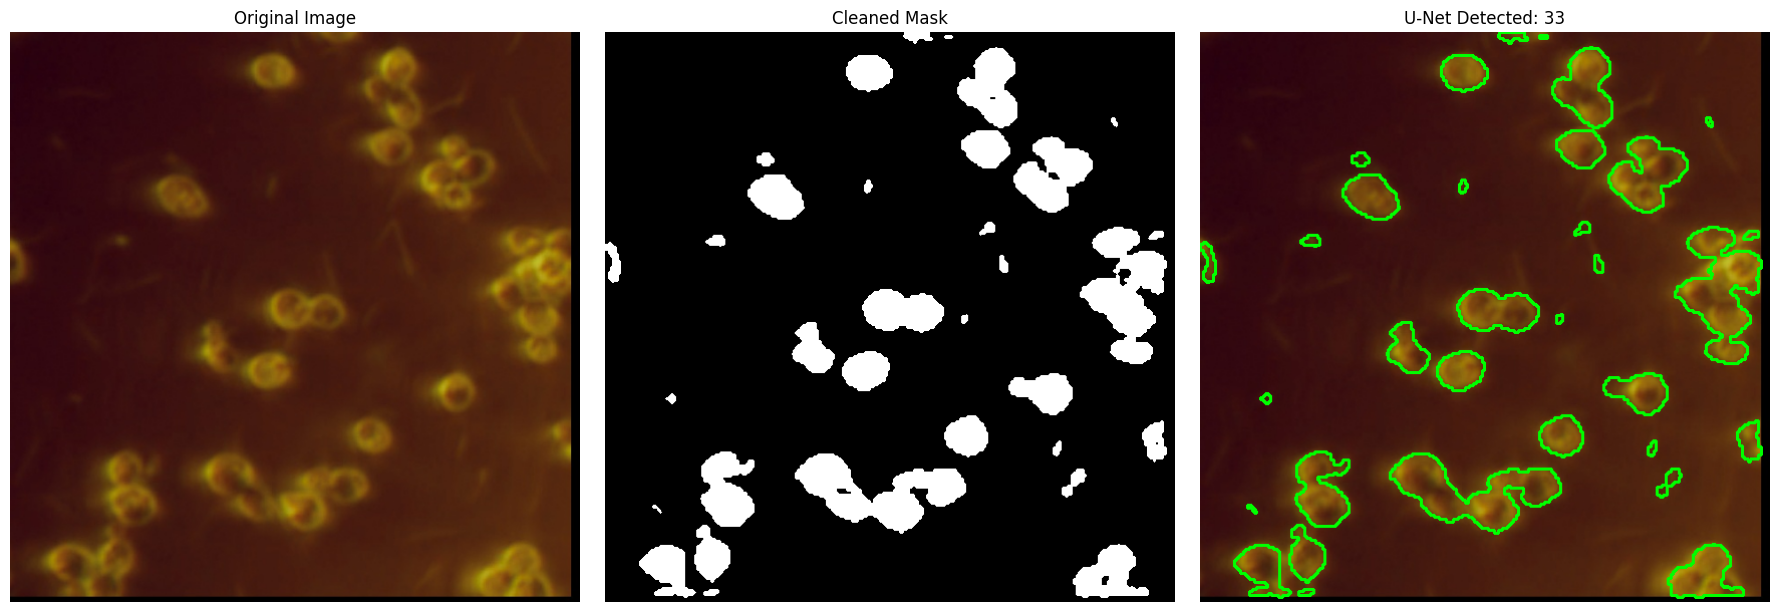

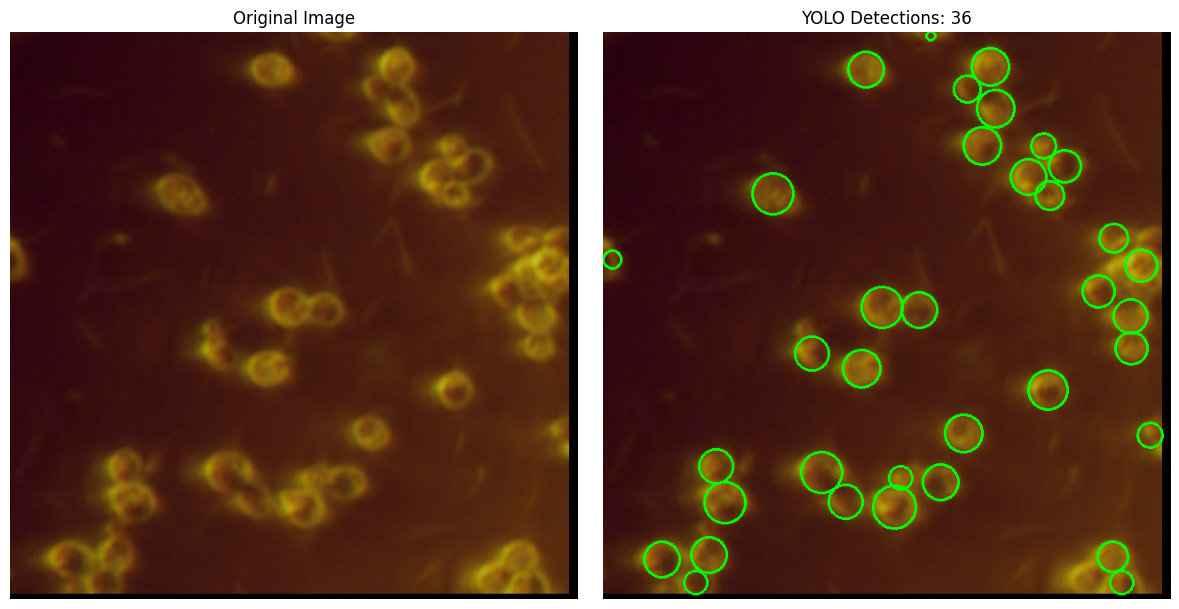

Ảnh 40/105: GT=36, UNet=32, YOLO=35
Ảnh 41/105: GT=36, UNet=27, YOLO=36
Ảnh 42/105: GT=36, UNet=25, YOLO=32
Ảnh 43/105: GT=46, UNet=46, YOLO=31
Ảnh 44/105: GT=46, UNet=42, YOLO=42
   ---> Đang hiển thị kết quả trực quan cho ảnh 44...


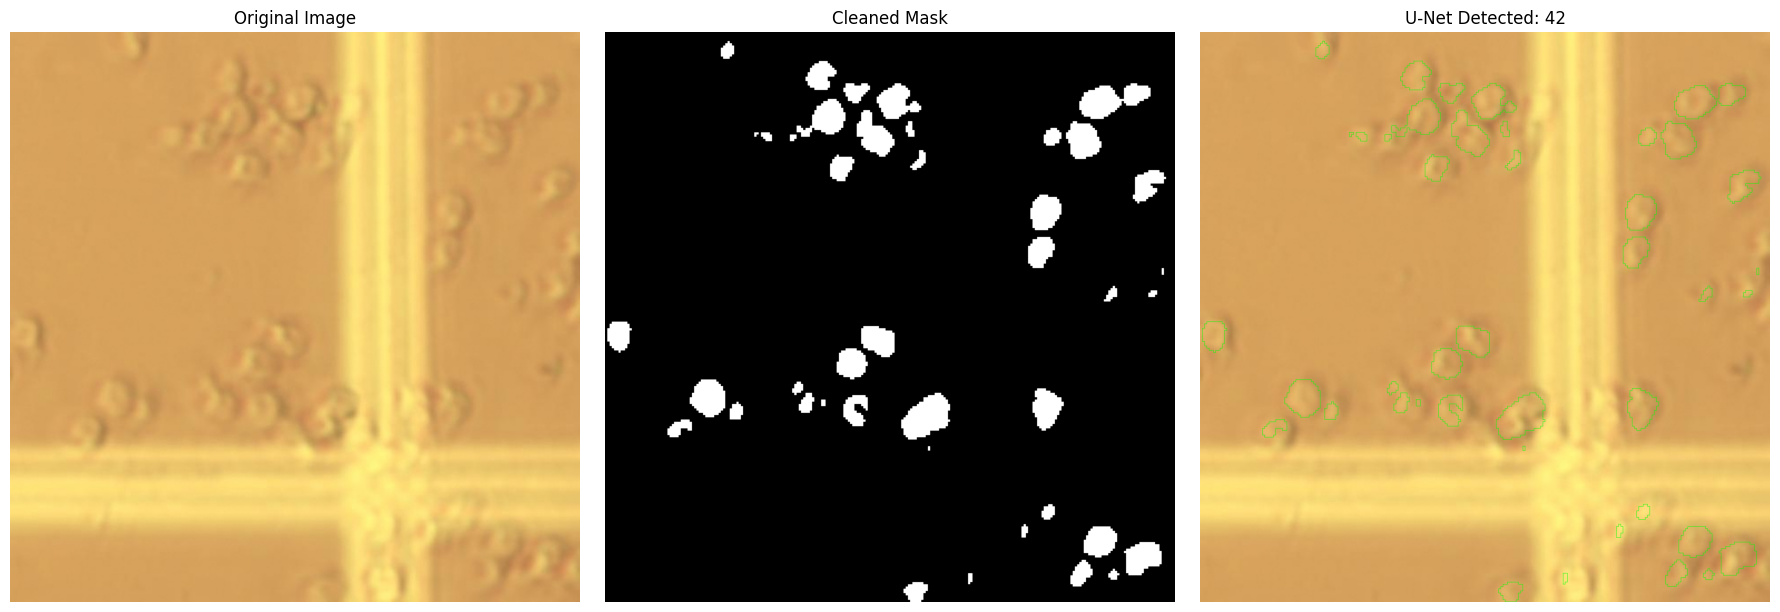

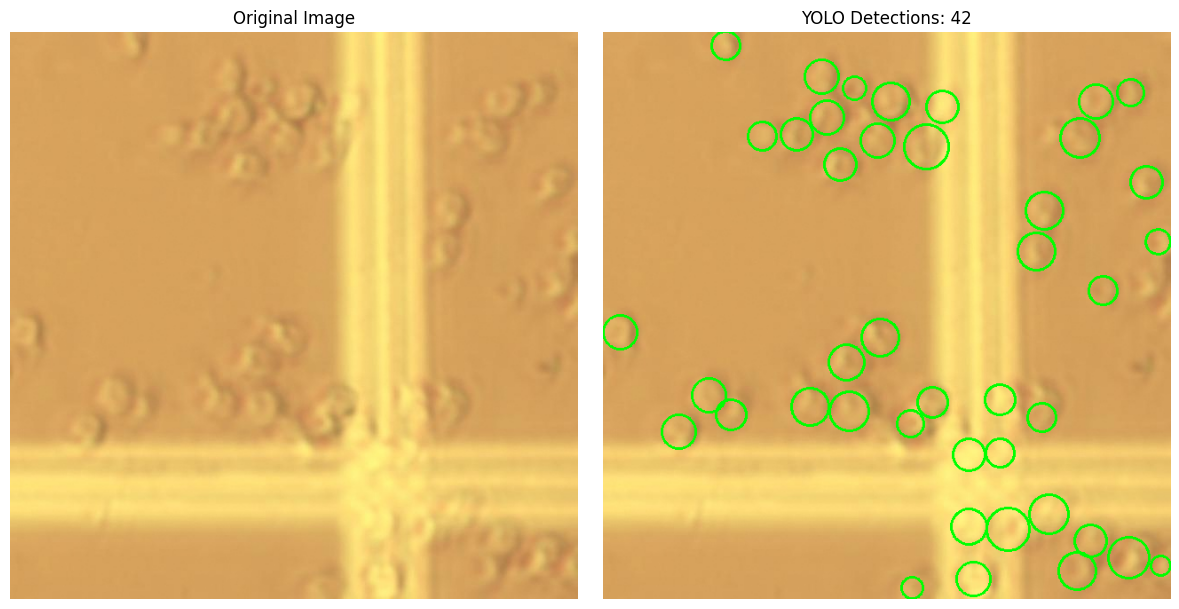

Ảnh 45/105: GT=46, UNet=45, YOLO=34
Ảnh 46/105: GT=60, UNet=47, YOLO=59
Ảnh 47/105: GT=60, UNet=36, YOLO=56
Ảnh 48/105: GT=60, UNet=56, YOLO=59
   ---> Đang hiển thị kết quả trực quan cho ảnh 48...


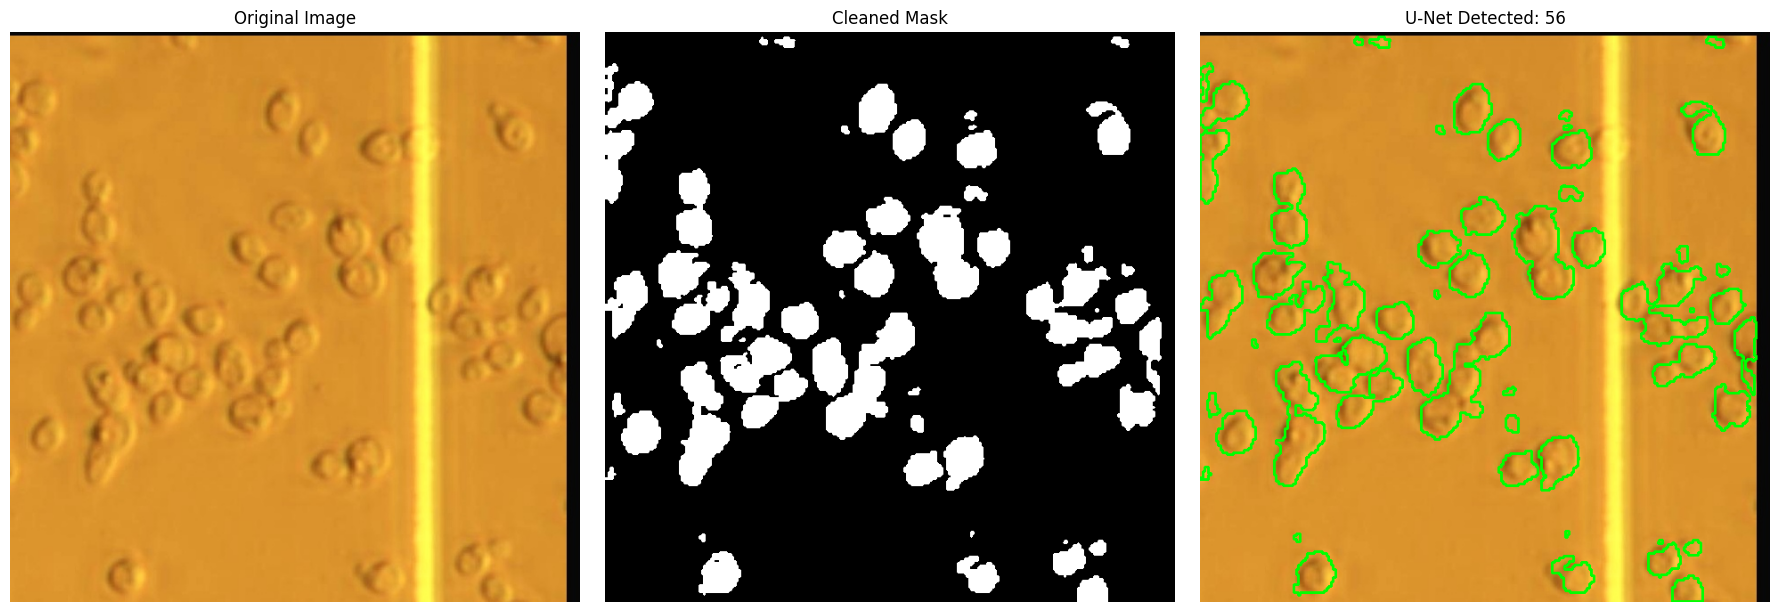

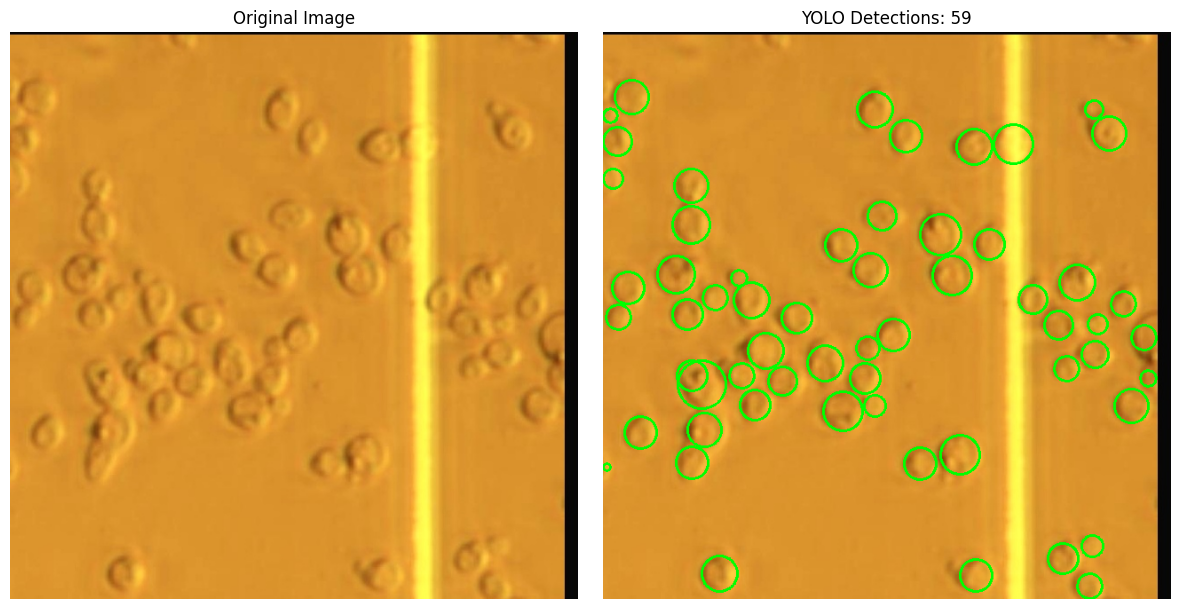

Ảnh 49/105: GT=236, UNet=138, YOLO=107
Ảnh 50/105: GT=236, UNet=125, YOLO=154
Ảnh 51/105: GT=236, UNet=111, YOLO=123
Ảnh 52/105: GT=258, UNet=173, YOLO=112
Ảnh 53/105: GT=258, UNet=181, YOLO=114
Ảnh 54/105: GT=258, UNet=179, YOLO=97
Ảnh 55/105: GT=365, UNet=195, YOLO=213
Ảnh 56/105: GT=365, UNet=195, YOLO=213
Ảnh 57/105: GT=365, UNet=198, YOLO=222
Ảnh 58/105: GT=874, UNet=232, YOLO=300
Ảnh 59/105: GT=874, UNet=251, YOLO=300
Ảnh 60/105: GT=874, UNet=242, YOLO=300
Ảnh 61/105: GT=913, UNet=298, YOLO=300
Ảnh 62/105: GT=913, UNet=341, YOLO=300
Ảnh 63/105: GT=913, UNet=259, YOLO=300
Ảnh 64/105: GT=740, UNet=361, YOLO=300
Ảnh 65/105: GT=740, UNet=456, YOLO=300
Ảnh 66/105: GT=740, UNet=441, YOLO=300
Ảnh 67/105: GT=838, UNet=339, YOLO=300
Ảnh 68/105: GT=838, UNet=244, YOLO=300
Ảnh 69/105: GT=838, UNet=257, YOLO=300
Ảnh 70/105: GT=422, UNet=251, YOLO=300
Ảnh 71/105: GT=422, UNet=241, YOLO=300
Ảnh 72/105: GT=422, UNet=246, YOLO=300
Ảnh 73/105: GT=401, UNet=202, YOLO=162
Ảnh 74/105: GT=401, UNet=2

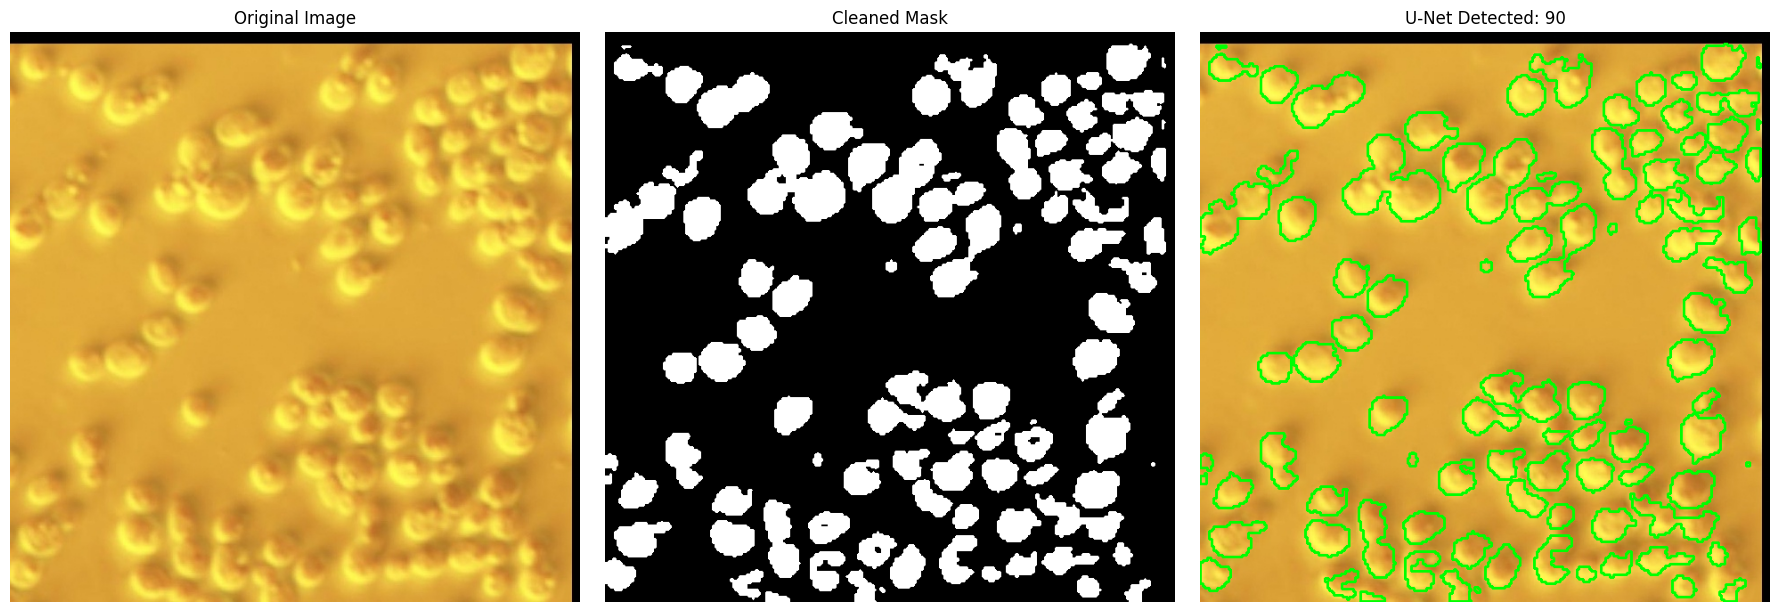

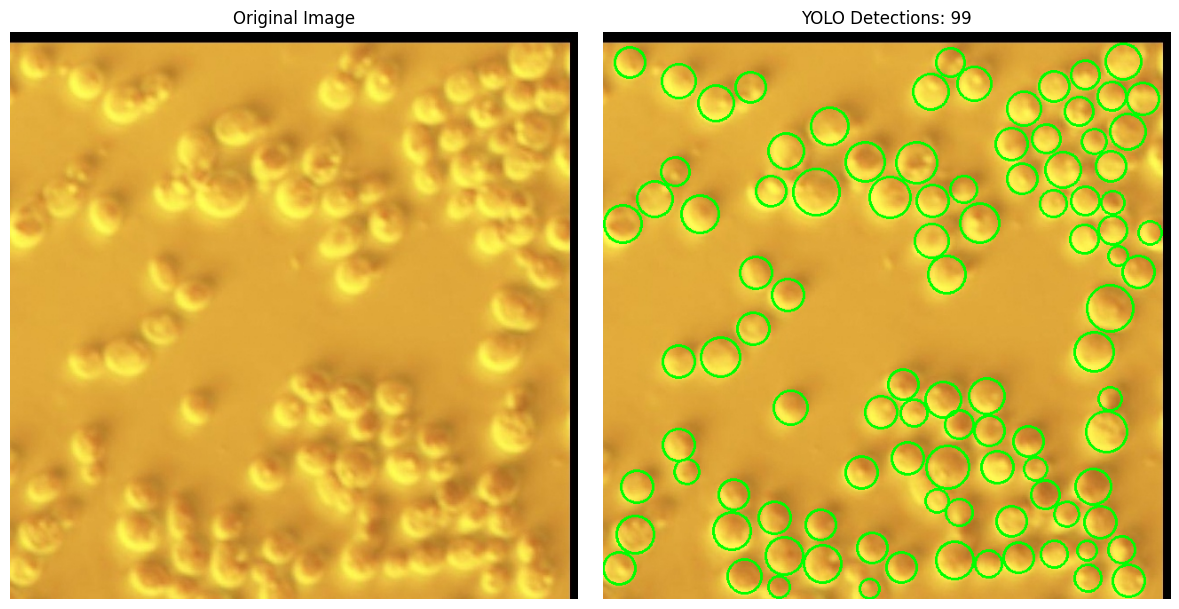

Ảnh 95/105: GT=99, UNet=71, YOLO=81
Ảnh 96/105: GT=99, UNet=83, YOLO=76
Ảnh 97/105: GT=43, UNet=27, YOLO=46
Ảnh 98/105: GT=43, UNet=24, YOLO=49
Ảnh 99/105: GT=43, UNet=25, YOLO=46
Ảnh 100/105: GT=298, UNet=145, YOLO=194
Ảnh 101/105: GT=298, UNet=124, YOLO=145
Ảnh 102/105: GT=298, UNet=109, YOLO=129
Ảnh 103/105: GT=300, UNet=127, YOLO=205
Ảnh 104/105: GT=300, UNet=129, YOLO=201
Ảnh 105/105: GT=300, UNet=127, YOLO=202


In [ ]:
# ===================================================================
# VÒNG LẶP ĐÁNH GIÁ, TINH CHỈNH VÀ TRỰC QUAN HÓA
# ===================================================================

# --- Load Ground Truth ---
df_gt = pd.read_excel("/kaggle/input/true-value-cell-counting/aug-true-value.xlsx")
true_counts = df_gt["True values"].tolist()
img_dir = "/kaggle/input/cell-counting-roboflow-segmentation-masks/aug_inference_only/images"
img_paths = [os.path.join(img_dir, f) for f in sorted_list]
assert len(img_paths) == len(true_counts), f"Số lượng ảnh ({len(img_paths)}) và GT ({len(true_counts)}) không khớp!"

# --- Vòng lặp chính ---
y_true, y_pred_unet, y_pred_yolo = [], [], []

UNET_MIN_CELL_AREA = 20     
YOLO_CONF_THRESHOLD = 0.5     
indices_to_visualize = [7, 10, 12, 18, 25, 38, 43, 47, 93]
# -------------------------------------------------------------------

print(f"Bắt đầu đánh giá trên {len(img_paths)} ảnh...")
print(f"Tham số U-Net: min_area = {UNET_MIN_CELL_AREA}")
print(f"Tham số YOLO: conf_threshold = {YOLO_CONF_THRESHOLD}")
print(f"Các ảnh sẽ được hiển thị kết quả: {indices_to_visualize}")
print("-" * 60)

for i, img_path in enumerate(img_paths):
    gt = true_counts[i]
    
    # --- U-Net pipeline ---
    pred_unet, final_mask, unet_img = unet_counting_pipeline(
        model_unet, device, img_path, test_transform, min_area=UNET_MIN_CELL_AREA
    )
    
    # --- YOLO pipeline ---
    pred_yolo, yolo_img, yolo_results = count_cells_yolo(
        model_yolo, img_path, conf_threshold=YOLO_CONF_THRESHOLD
    )

    y_true.append(gt)
    y_pred_unet.append(pred_unet)
    y_pred_yolo.append(pred_yolo)
    
    # In kết quả cho mỗi ảnh
    print(f"Ảnh {i+1}/{len(img_paths)}: GT={gt}, UNet={pred_unet}, YOLO={pred_yolo}")

    # --- Hiển thị kết quả nếu chỉ số nằm trong danh sách ---
    if i in indices_to_visualize:
        print(f"   ---> Đang hiển thị kết quả trực quan cho ảnh {i+1}...")
        if unet_img is not None:
            visualize_unet_prediction(unet_img, final_mask, pred_unet)
        if yolo_img is not None:
            visualize_yolo_prediction(yolo_img, yolo_results, pred_yolo)

In [9]:
metrics_data = []
models = {"U-Net": y_pred_unet, "YOLO": y_pred_yolo}

for model_name, y_pred in models.items():
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics_data.append({
        "Model": model_name, "MSE": f"{mse:.2f}", "MAE": f"{mae:.2f}",
        "MAPE": f"{mape}", "R2 Score": f"{r2:.2f}"
    })

df_metrics = pd.DataFrame(metrics_data)
print("\n" + "="*50)
print("--- BẢNG KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---")
print("="*50)
print(df_metrics.to_string(index=False))


--- BẢNG KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---
Model      MSE    MAE                MAPE R2 Score
U-Net 43043.62 121.71 0.34530163692803556     0.32
 YOLO 39376.08 107.71  0.2645376119165202     0.38



--- DISPERSION STATISTICS (Độ lệch chuẩn của Absolute Errors) ---
U-Net: Std of Absolute Errors = 168.02
YOLO: Std of Absolute Errors = 166.65


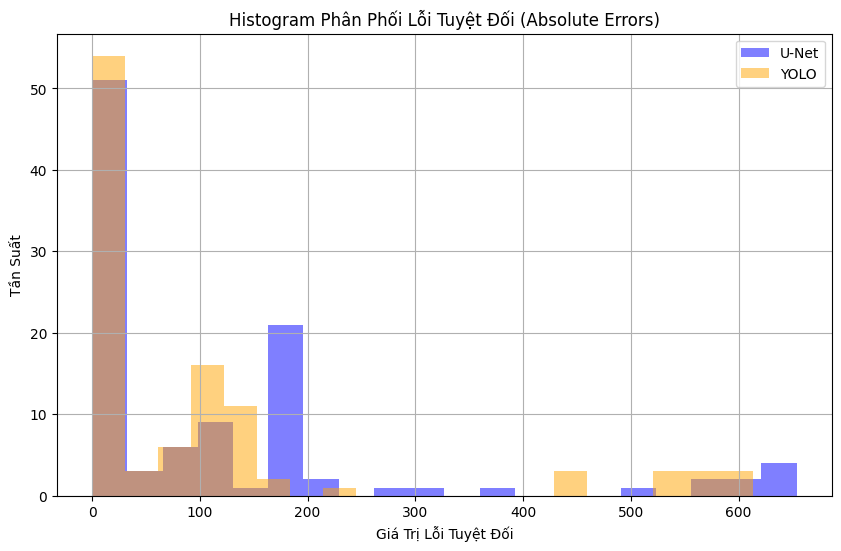

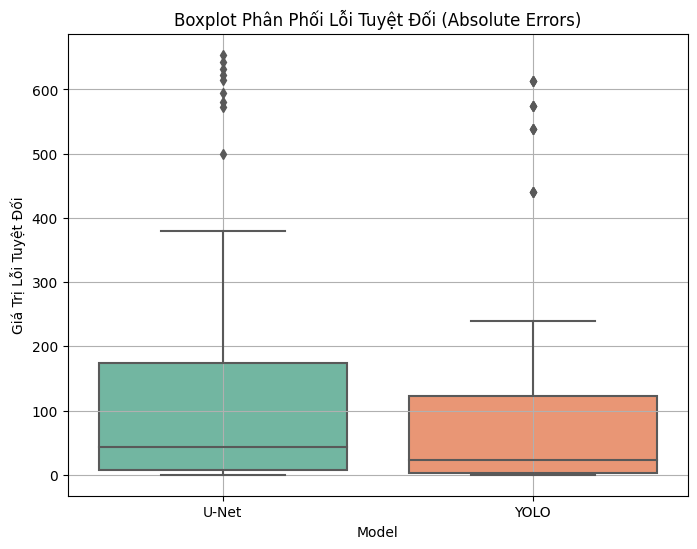

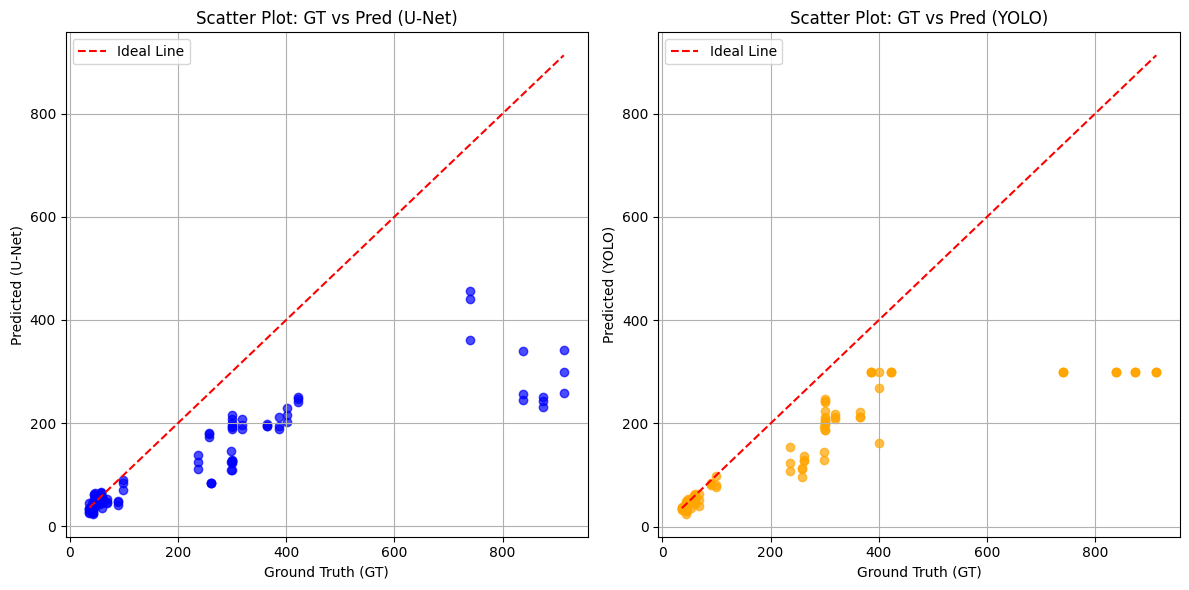

In [ ]:
# ===================================================================
# PHÂN TÍCH LỖI VÀ TRỰC QUAN HÓA THÊM
# ===================================================================
import seaborn as sns

# Chuyển đổi lists thành numpy arrays để tính toán dễ dàng
y_true_np = np.array(y_true)
y_pred_unet_np = np.array(y_pred_unet)
y_pred_yolo_np = np.array(y_pred_yolo)

# Tính absolute errors (lỗi tuyệt đối) cho từng mẫu
abs_errors_unet = np.abs(y_true_np - y_pred_unet_np)
abs_errors_yolo = np.abs(y_true_np - y_pred_yolo_np)

# Tính dispersion statistics: Độ lệch chuẩn của absolute errors (std of MAE per sample)
std_unet = np.std(abs_errors_unet)
std_yolo = np.std(abs_errors_yolo)

# In kết quả dispersion statistics
print("\n" + "="*50)
print("--- DISPERSION STATISTICS (Độ lệch chuẩn của Absolute Errors) ---")
print("="*50)
print(f"U-Net: Std of Absolute Errors = {std_unet:.2f}")
print(f"YOLO: Std of Absolute Errors = {std_yolo:.2f}")

# 1. Histogram phân phối lỗi (Absolute Errors)
plt.figure(figsize=(10, 6))
plt.hist(abs_errors_unet, bins=20, alpha=0.5, label='U-Net', color='blue')
plt.hist(abs_errors_yolo, bins=20, alpha=0.5, label='YOLO', color='orange')
plt.title('Histogram Phân Phối Lỗi Tuyệt Đối (Absolute Errors)')
plt.xlabel('Giá Trị Lỗi Tuyệt Đối')
plt.ylabel('Tần Suất')
plt.legend()
plt.grid(True)
plt.show()

# 2. Boxplot phân phối lỗi (Absolute Errors)
data_errors = pd.DataFrame({
    'Model': ['U-Net'] * len(abs_errors_unet) + ['YOLO'] * len(abs_errors_yolo),
    'Absolute Error': np.concatenate([abs_errors_unet, abs_errors_yolo])
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Model', y='Absolute Error', data=data_errors, palette='Set2')
plt.title('Boxplot Phân Phối Lỗi Tuyệt Đối (Absolute Errors)')
plt.ylabel('Giá Trị Lỗi Tuyệt Đối')
plt.grid(True)
plt.show()

# 3. Scatter plot GT vs Pred cho từng model
plt.figure(figsize=(12, 6))

# Scatter cho U-Net
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_unet, alpha=0.7, color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Line')
plt.title('Scatter Plot: GT vs Pred (U-Net)')
plt.xlabel('Ground Truth (GT)')
plt.ylabel('Predicted (U-Net)')
plt.legend()
plt.grid(True)

# Scatter cho YOLO
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_yolo, alpha=0.7, color='orange')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Line')
plt.title('Scatter Plot: GT vs Pred (YOLO)')
plt.xlabel('Ground Truth (GT)')
plt.ylabel('Predicted (YOLO)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()